# Prediction

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRFRegressor
import xgboost as xgb
import graphviz

from pandas.tseries.holiday import USFederalHolidayCalendar

from IPython.display import Image

In [2]:
# import datasets stored as csv

bike_data = pd.read_csv("data/sf_2019_prepared.csv")
weather_data = pd.read_csv("data/weather_hourly_sf_prepared.csv")

In [3]:
# type cast to timestamps

bike_data[['ts_start_hour','start_time', 'end_time']] = bike_data[['ts_start_hour','start_time', 'end_time']].apply(pd.to_datetime)

weather_data['date_time'] = weather_data['date_time'].apply(pd.to_datetime)

In [4]:
bike_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960323 entries, 0 to 1960322
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_time               1960323 non-null  datetime64[ns]
 1   end_time                 1960323 non-null  datetime64[ns]
 2   start_station_id         1879999 non-null  float64       
 3   end_station_id           1884835 non-null  float64       
 4   start_station_name       1880598 non-null  object        
 5   end_station_name         1885259 non-null  object        
 6   bike_id                  1960323 non-null  int64         
 7   user_type                1960323 non-null  object        
 8   ts_start_hour            1960323 non-null  datetime64[ns]
 9   start_hour               1960323 non-null  int64         
 10  start_weekday            1960323 non-null  int64         
 11  start_month              1960323 non-null  int64         
 12  

In [5]:
weather_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  8756 non-null   datetime64[ns]
 1   max_temp   8756 non-null   float64       
 2   min_temp   8756 non-null   float64       
 3   precip     8756 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 273.8 KB


### Preparation prediction_df
Creation of a small data set for predicting the hourly usage of the bike fleet. Bike/Trip data is aggregated and the hourly demand is calculated. Location data is not part of the prediction_df since the hourly demand of the whole bike fleet needs to be determined. Information on station granularity is therefore not considered. The weather data is reduced to the columns max_temp and precip. 

In [6]:
bike_data.set_index("ts_start_hour", inplace=True)
bike_data['number_of_trips'] = 1
bike_data['number_of_trips_subscriber'] = np.where(bike_data['user_type']== 'Subscriber', 1, 0)
bike_data['number_of_trips_customer'] = np.where(bike_data['user_type']== 'Customer', 1, 0)
bike_data_agg = bike_data.groupby("ts_start_hour").sum()
bike_data_agg['subscriber_ratio'] = bike_data_agg['number_of_trips_subscriber']/bike_data_agg['number_of_trips']
trips_per_hour = bike_data_agg[['number_of_trips', 'subscriber_ratio']]
trips_per_hour

/tmp/ipykernel_3544/3951905254.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bike_data_agg = bike_data.groupby("ts_start_hour").sum()


number_of_trips  subscriber_ratio
ts_start_hour                                         
2019-01-01 00:00:00               58          0.568966
2019-01-01 01:00:00               71          0.633803
2019-01-01 02:00:00               35          0.542857
2019-01-01 03:00:00                9          0.777778
2019-01-01 04:00:00                4          0.750000
...                              ...               ...
2019-12-31 19:00:00              167          0.556886
2019-12-31 20:00:00              147          0.448980
2019-12-31 21:00:00               96          0.614583
2019-12-31 22:00:00              102          0.509804
2019-12-31 23:00:00              105          0.323810

[8744 rows x 2 columns]

In [7]:
weather_data.set_index("date_time", inplace=True)
prediction_df = weather_data[["max_temp", "precip"]].copy()
prediction_df = prediction_df.join(trips_per_hour)

prediction_df

max_temp  precip  number_of_trips  subscriber_ratio
date_time                                                               
2019-01-01 00:00:00       9.4     0.0             58.0          0.568966
2019-01-01 01:00:00       8.9     0.0             71.0          0.633803
2019-01-01 02:00:00       8.3     0.0             35.0          0.542857
2019-01-01 03:00:00       8.9     0.0              9.0          0.777778
2019-01-01 04:00:00       8.3     0.0              4.0          0.750000
...                       ...     ...              ...               ...
2019-12-31 19:00:00      10.0     0.0            167.0          0.556886
2019-12-31 20:00:00      10.0     0.0            147.0          0.448980
2019-12-31 21:00:00      11.7     0.0             96.0          0.614583
2019-12-31 22:00:00      10.0     0.0            102.0          0.509804
2019-12-31 23:00:00      10.0     0.0            105.0          0.323810

[8756 rows x 4 columns]

### Feature Engineering
Adding additional features based on the results of the descriptive analyses and clutering.

In [8]:
# adding seasonal features
#  
prediction_df['is_weekend'] = prediction_df.index.weekday >= 5
prediction_df['is_weekend'] = prediction_df['is_weekend'].map(lambda x: 1 if x == True else 0)
prediction_df['is_holiday'] = prediction_df.index.floor('d').isin(USFederalHolidayCalendar().holidays(start=prediction_df.index.min(), end=prediction_df.index.max()))
prediction_df['is_holiday'] = prediction_df['is_holiday'].map(lambda x: 1 if x == True else 0)
prediction_df['is_workday'] = (prediction_df['is_holiday'] + prediction_df['is_weekend']) == 0
prediction_df['is_workday'] = prediction_df['is_workday'].map(lambda x: 1 if x == True else 0)

# adding lag features
## TOTAL
prediction_df['lag_trips_hour_1'] = prediction_df.number_of_trips.shift(1)
prediction_df['lag_trips_hour_2'] = prediction_df.number_of_trips.shift(2)
prediction_df['lag_trips_hour_3'] = prediction_df.number_of_trips.shift(3)

prediction_df['lag_trips_day_1'] = prediction_df.number_of_trips.shift(24)

prediction_df['lag_trips_week_1'] = prediction_df.number_of_trips.shift(7*24)

# subscriber_ratio

prediction_df['lag_ratio_hour_1'] = prediction_df.subscriber_ratio.shift(1)
prediction_df['lag_ratio_hour_2'] = prediction_df.subscriber_ratio.shift(2)
prediction_df['lag_ratio_hour_3'] = prediction_df.subscriber_ratio.shift(3)

prediction_df['lag_ratio_day_1'] = prediction_df.subscriber_ratio.shift(24)

prediction_df['lag_ratio_week_1'] = prediction_df.subscriber_ratio.shift(7*24)

# drop nan values caused by the lag features (shift of 1 week means the first week of the year is filled with nan and can't be used)
prediction_df = prediction_df.dropna()


prediction_df.sample(5)

max_temp  precip  number_of_trips  subscriber_ratio  \
date_time                                                                  
2019-02-14 17:00:00      12.8     0.0            985.0          0.865990   
2019-12-13 12:00:00      13.9     1.0            205.0          0.429268   
2019-03-29 10:00:00      13.3     0.0            378.0          0.801587   
2019-12-07 11:00:00      17.2     0.0            183.0          0.568306   
2019-07-09 03:00:00      15.0     0.0              5.0          0.800000   

                     is_weekend  is_holiday  is_workday  lag_trips_hour_1  \
date_time                                                                   
2019-02-14 17:00:00           0           0           1             552.0   
2019-12-13 12:00:00           0           0           1             212.0   
2019-03-29 10:00:00           0           0           1             810.0   
2019-12-07 11:00:00           1           0           0             177.0   
2019-07-09 03:00:00           0           0           1               5.0   

                     lag_trips_hour_2  lag_trips_hour_3  lag_trips_day_1  \
date_time                                                                  
2019-02-14 17:00:00             227.0             159.0            417.0   
2019-12-13 12:00:00             258.0             682.0            112.0   
2019-03-29 10:00:00             968.0             419.0            352.0   
2019-12-07 11:00:00             143.0              87.0            231.0   
2019-07-09 03:00:00              10.0              19.0              5.0   

                     lag_trips_week_1  lag_ratio_hour_1  lag_ratio_hour_2  \
date_time                                                                   
2019-02-14 17:00:00             883.0          0.889493          0.894273   
2019-12-13 12:00:00             217.0          0.424528          0.403101   
2019-03-29 10:00:00             288.0          0.893827          0.898760   
2019-12-07 11:00:00              31.0          0.553672          0.657343   
2019-07-09 03:00:00               4.0          0.600000          0.500000   

                     lag_ratio_hour_3  lag_ratio_day_1  lag_ratio_week_1  
date_time                                                                 
2019-02-14 17:00:00          0.911950         0.923261          0.887882  
2019-12-13 12:00:00          0.382698         0.491071          0.622120  
2019-03-29 10:00:00          0.899761         0.900568          0.878472  
2019-12-07 11:00:00          0.689655         0.666667          0.548387  
2019-07-09 03:00:00          0.947368         1.000000          1.000000

<AxesSubplot: >

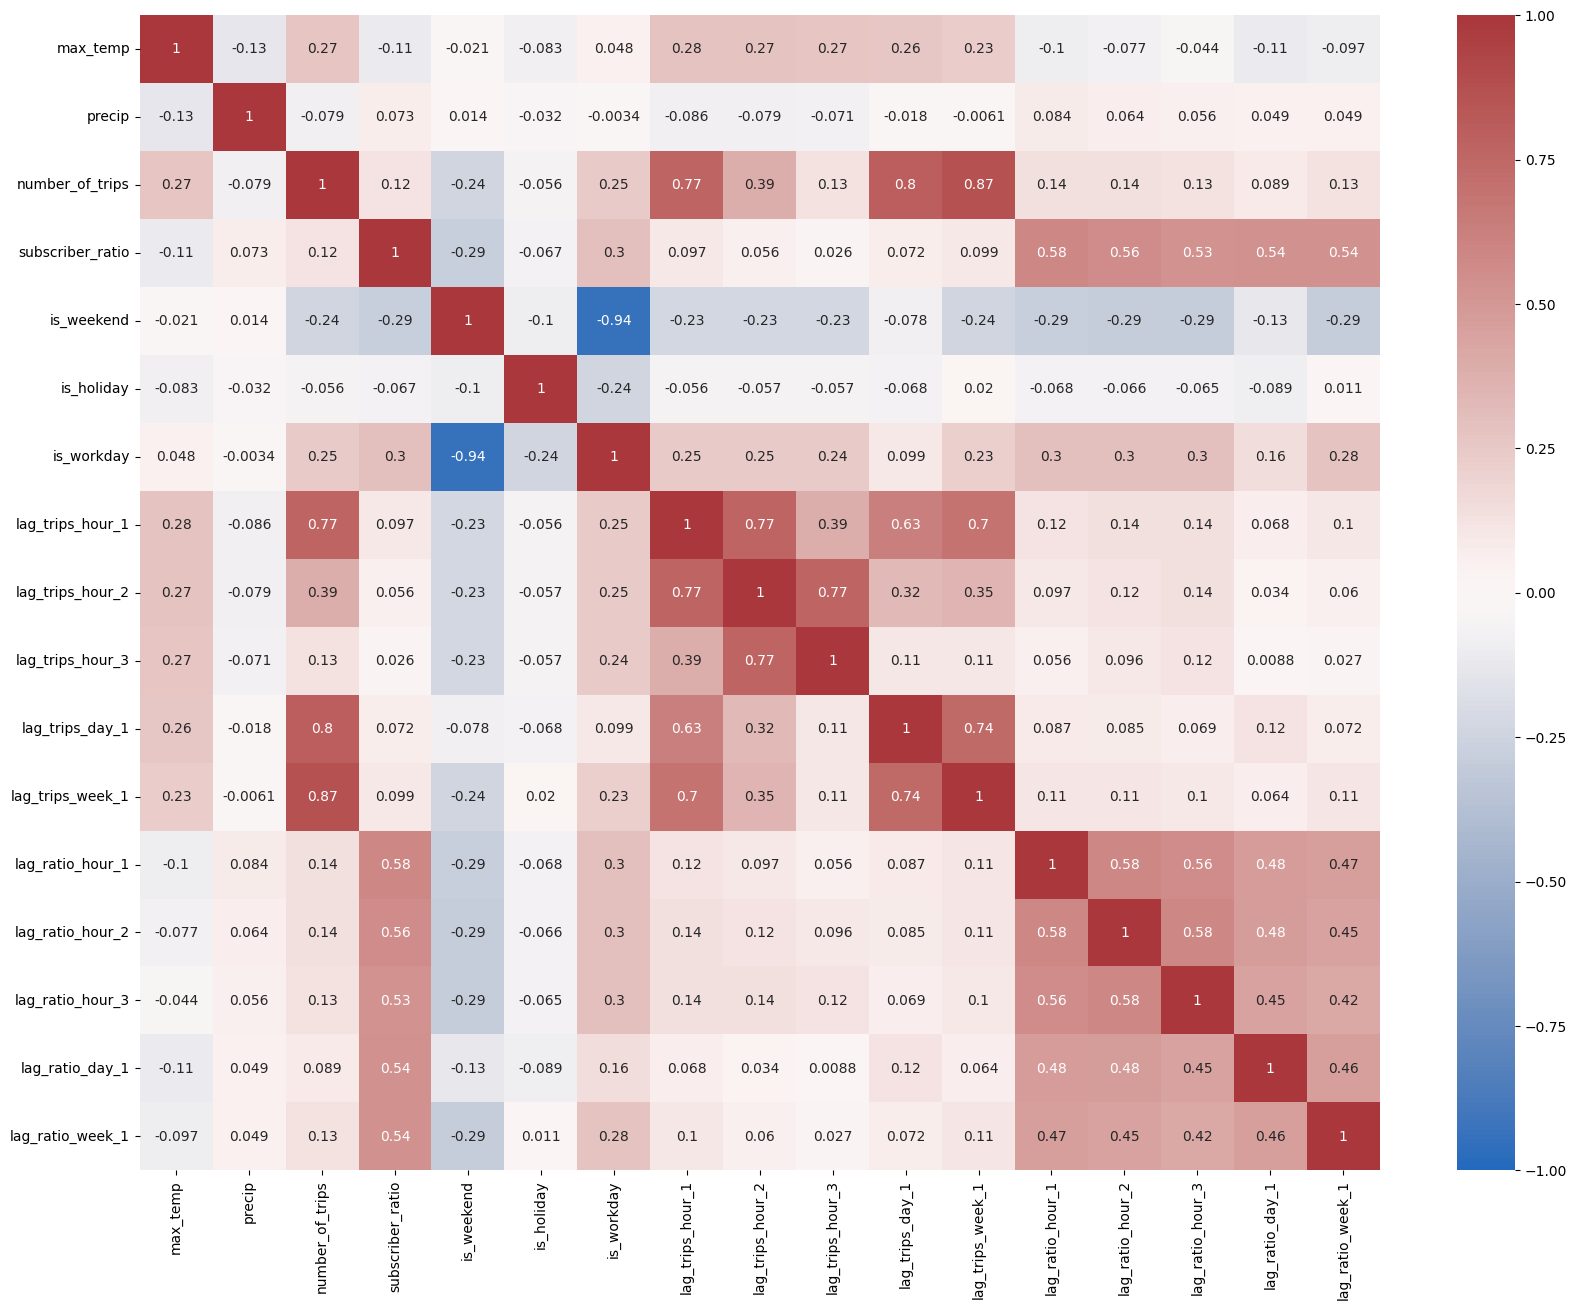

In [9]:
pred_corr_df = prediction_df.corr()
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
sns.heatmap(pred_corr_df, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag')


## Prediction preparation 

### Grid search cross validation (GridSearchCV) and Train/ Test Splitting
To find the best combination of parameters for our models we are using `GridSearchCV`.  
It does an exhaustive search over all parameters, that are provided via the `gird_params` dict.

`GridSearchCV` splits the data into multiple training and test sets and the algorithm for this can be chosen.
By default it uses the `KFold` algorithm, which splits the dataset into multiple train/ test sets with the same percentage of samples  
The problem is that this algorithm is not suitable for time series dataset like we have, because it assumes that the samples are independent.  
This is because time series data always has the some sort of dependency to data from the past.
The `KFold` algorithm would not ensure that the model works only on training data:

In [10]:
# embedding images in vscode jupyter notebooks is complicated...
# https://github.com/microsoft/vscode/issues/121256

# this is the only easy way i found
Image(url="./report/images/kfold_algorithm.png")


Instead, we are using the `TimeSeriesSplit` algorithm with is, like `KFold` implemented as a generator, so it's a drop-in replacement.  
`TimeSeriesSplit` ensures that a fitted model is only evaluated on "future" data.

[report/images/timeseriessplit_algorithm.png]


Read more here and find the source for the pictures here: https://scikit-learn.org/stable/modules/cross_validation.html#k-fold

We decided to go with 3 folds or train/ test splits, which is a bit less than the default value of 5.  
But we prefer a focus different parameter combinations and since we only have limited computation power, this is the trade-off that has to be done.  
Read more here: https://scikit-learn.org/stable/modules/cross_validation.html#k-fold



In [11]:
Image(url="./report/images/timeseriessplit_algorithm.png")


But still, we want to be able to do a final evaluation after the grid search, especially for visualization purposes.  
We cannot simply take the train/test samples that are generated using `TimeSeriesSplit`, because after the best parameters are found, the model is refitted.  
This means that the model is once again trained on the whole dataset and test results would be unrealisticly high. 

So we preserve a 30% share as our test set of our whole dataset that is only used for the final evaluation.  
For this we are using the `train_test_split` helper function with `shuffle=False` because we are dealing with time series data.
We take the later (?) 30% as our test set, to again evaluate our model on "future" data, that has not already influenced the model.
The grid search is started with the remaining 70%.

In [12]:
# Split train and test set
X = prediction_df.drop(["number_of_trips"],axis=1).copy()
y = prediction_df.number_of_trips

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False, random_state=42)

X_test : pd.DataFrame
print(f"This should be the last 30% of the year \n", X_test.index)

# Create the time series specific cross-validator
tscv = TimeSeriesSplit(n_splits=3)

This should be the last 30% of the year 
 DatetimeIndex(['2019-09-15 14:00:00', '2019-09-15 15:00:00',
               '2019-09-15 16:00:00', '2019-09-15 17:00:00',
               '2019-09-15 18:00:00', '2019-09-15 19:00:00',
               '2019-09-15 20:00:00', '2019-09-15 21:00:00',
               '2019-09-15 22:00:00', '2019-09-15 23:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=2550, freq=None)


## Random Forest Regression

### Default model

We also use GridSearchCV here, to make the cross validation easier and the results comparable to the actual grid search executions later.
For now we leave out any parameters and just use the model as it is by default.

In [13]:
rf_default_grid = GridSearchCV(estimator=RandomForestRegressor(random_state = 42), param_grid={}, cv=tscv, n_jobs=-1)
rf_default_grid.fit(X_train, y_train)

print("Default model score: ", rf_default_grid.best_score_)

Default model score:  0.9221879454170073


### Parameter tuning

min_samples_split: The minimum number of samples required to split an internal node  
min_samples_leaf: The minimum number of samples required to be at a leaf node  
ccp_alpha: complexity parameter for Minimal Cost-Complexity Pruning  
n_estimators: The number of trees in the forest.  

In [14]:
rf_params = {'min_samples_split': [2, 3, 4],  # 2 is the default 
              'min_samples_leaf': [1, 2, 3], # 1 is the default
              'ccp_alpha': [0, 0.005, 0.05], # 0 is the default
              'n_estimators': [100,70,50,30] # 100 is the default
              }

#Using this RandomizedSearch we only found combinations that have a worse score than the default...
# Going with good old GridSearch again
# n_jobs= -1 means that we use all available cores, which is very important since RandomForestRegressor is single-threaded 
rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_params,  cv=tscv, verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   1.7s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.8s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.4s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   5.0s
[CV] END ccp_alpha=0, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   4.0s
[CV] END ccp_alpha=0, min_samples_leaf=1, min

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.005, 0.05],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 70, 50, 30]},
             verbose=2)

In [15]:
print("score: ", rf_grid.best_score_)
print("best parameters: ", rf_grid.best_params_)

score:  0.9221968874016246
best parameters:  {'ccp_alpha': 0.05, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


#### Visualization of the results

In [16]:
rf_grid_df = pd.DataFrame(rf_grid.cv_results_)
rf_grid_df.sort_values("mean_test_score", inplace=True)
rf_grid_df.reset_index(drop=True, inplace=True)
rf_grid_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.429300      0.643708         0.022260        0.005025   
1       1.514268      0.620823         0.017988        0.000902   
2       1.693328      0.879838         0.017181        0.000357   
3       1.271253      0.549605         0.016785        0.000787   
4       1.177442      0.528712         0.016227        0.000678   

  param_ccp_alpha param_min_samples_leaf param_min_samples_split  \
0               0                      1                       4   
1           0.005                      1                       4   
2            0.05                      1                       4   
3           0.005                      3                       4   
4           0.005                      3                       2   

  param_n_estimators                                             params  \
0                 30  {'ccp_alpha': 0, 'min_samples_leaf': 1, 'min_s...   
1                 30  {'ccp_alpha': 0.005, 'min_samples_leaf': 1, 'm...   
2                 30  {'ccp_alpha': 0.05, 'min_samples_leaf': 1, 'mi...   
3                 30  {'ccp_alpha': 0.005, 'min_samples_leaf': 3, 'm...   
4                 30  {'ccp_alpha': 0.005, 'min_samples_leaf': 3, 'm...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.906102           0.906890           0.939563         0.917518   
1           0.906102           0.906892           0.939561         0.917518   
2           0.906100           0.906898           0.939559         0.917519   
3           0.905842           0.907855           0.940657         0.918118   
4           0.905842           0.907855           0.940657         0.918118   

   std_test_score  rank_test_score  
0        0.015591              108  
1        0.015590              107  
2        0.015588              106  
3        0.015959              103  
4        0.015959              103

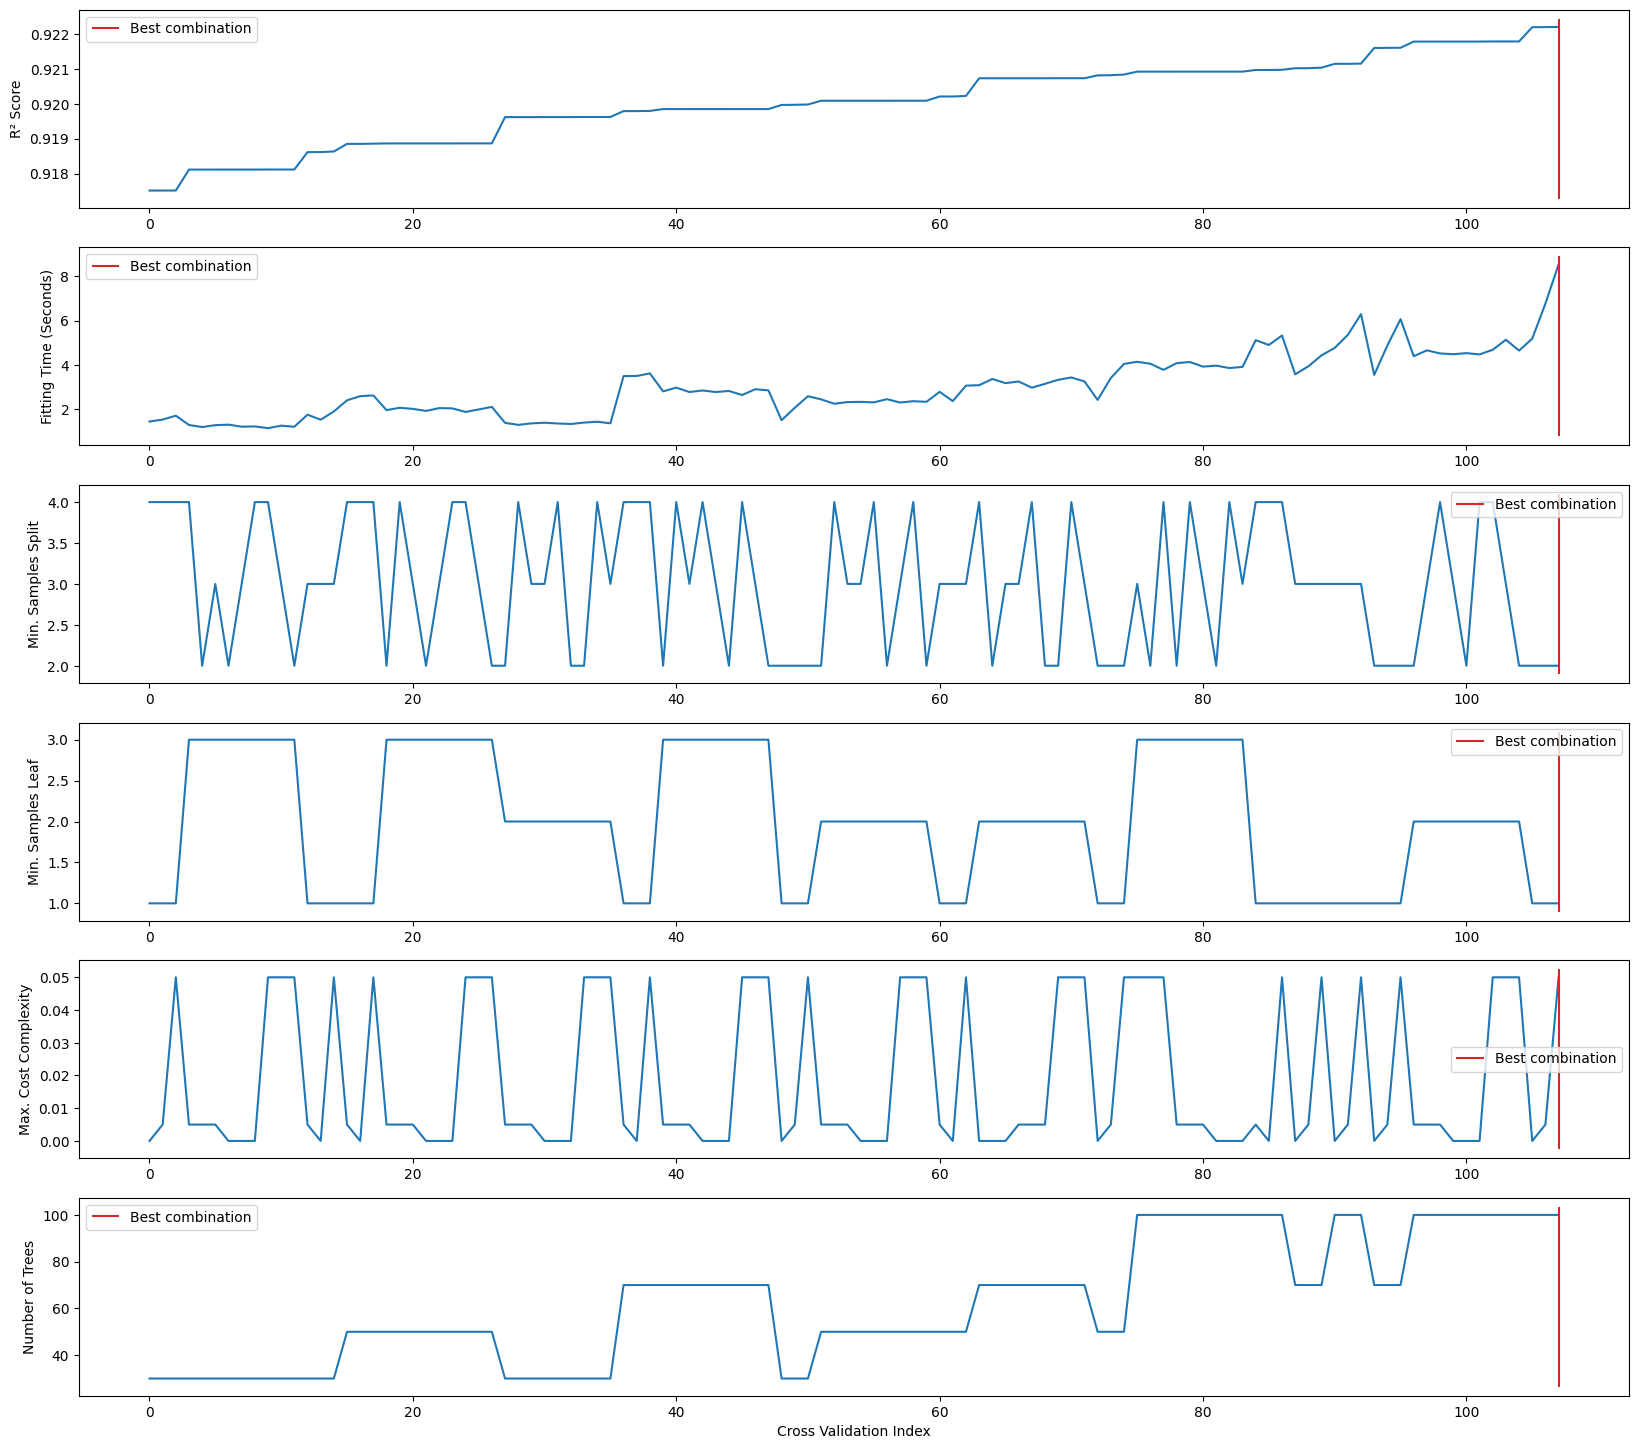

In [17]:
plot, axes = plt.subplots(nrows = 6, ncols = 1, figsize = (20,18))

best_combination = rf_grid_df[rf_grid_df["rank_test_score"] ==1].index

# GridSearchCV uses the scoring function of the estimator (XGBRFRegressor) which in this case is R²
axes[0].plot(rf_grid_df["mean_test_score"])
axes[0].vlines(best_combination, axes[0].get_ylim()[0], axes[0].get_ylim()[1], color="tab:red", label="Best combination") 
axes[0].set_ylabel("R² Score")
axes[0].legend(loc="best")

# It also takes the fitting time into account
axes[1].plot(rf_grid_df["mean_fit_time"])
axes[1].vlines(best_combination, axes[1].get_ylim()[0], axes[1].get_ylim()[1], color="tab:red", label="Best combination") 
axes[1].set_ylabel("Fitting Time (Seconds)")
axes[1].legend(loc="best")

# The selected parameters for tuning are displayed as well
axes[2].plot(rf_grid_df["param_min_samples_split"])
axes[2].vlines(best_combination, axes[2].get_ylim()[0], axes[2].get_ylim()[1], color="tab:red", label="Best combination") 
axes[2].set_ylabel("Min. Samples Split")
axes[2].legend(loc="best")

axes[3].plot(rf_grid_df["param_min_samples_leaf"])
axes[3].vlines(best_combination, axes[3].get_ylim()[0], axes[3].get_ylim()[1], color="tab:red", label="Best combination") 
axes[3].set_ylabel("Min. Samples Leaf")
axes[3].legend(loc="best")

axes[4].plot(rf_grid_df["param_ccp_alpha"])
axes[4].vlines(best_combination, axes[4].get_ylim()[0], axes[4].get_ylim()[1], color="tab:red", label="Best combination") 
axes[4].set_ylabel("Max. Cost Complexity")
axes[4].legend(loc="best")

axes[5].plot(rf_grid_df["param_n_estimators"])
axes[5].vlines(best_combination, axes[5].get_ylim()[0], axes[5].get_ylim()[1], color="tab:red", label="Best combination") 
axes[5].set_xlabel("Cross Validation Index")
axes[5].set_ylabel("Number of Trees")
axes[5].legend(loc="best")


This shows that the minimum leaf size, split size and maximum cost complexity should be as low as possible.
Actually the default values seems to have the best performance.
However, changing the number of trees to a lower value made an improvement in comparison to the default values.

The winner chosen by GridSearchCV has the following parameters:

- `n_estimators`: 50
- `min_samples_split`: 2
- `min_samples_leaf`: 1 
- `ccp_alpha` : 0

### Model evaluation

In [18]:
rf_grid.best_estimator_.predict(X_test)

array([277.73639683, 288.36252255, 299.16818326, ..., 115.92246703,
        54.57546537,  62.58402789])

In [19]:
rf_plt_df = pd.DataFrame(y_test).copy()
rf_plt_df['pred'] = rf_grid.best_estimator_.predict(X_test)
rf_plt_df['dif'] = (rf_plt_df.number_of_trips-rf_plt_df.pred).abs()
rf_plt_df['dif_perc'] = rf_plt_df['dif']/rf_plt_df['number_of_trips']
rf_plt_df

number_of_trips        pred        dif  dif_perc
date_time                                                            
2019-09-15 14:00:00            272.0  277.736397   5.736397  0.021090
2019-09-15 15:00:00            313.0  288.362523  24.637477  0.078714
2019-09-15 16:00:00            306.0  299.168183   6.831817  0.022326
2019-09-15 17:00:00            316.0  292.434255  23.565745  0.074575
2019-09-15 18:00:00            221.0  248.877003  27.877003  0.126140
...                              ...         ...        ...       ...
2019-12-31 19:00:00            167.0  144.976461  22.023539  0.131877
2019-12-31 20:00:00            147.0  118.173064  28.826936  0.196102
2019-12-31 21:00:00             96.0  115.922467  19.922467  0.207526
2019-12-31 22:00:00            102.0   54.575465  47.424535  0.464946
2019-12-31 23:00:00            105.0   62.584028  42.415972  0.403962

[2550 rows x 4 columns]

In [20]:
rf_plt_df.dif.describe()

count    2550.000000
mean       31.002159
std        40.965564
min         0.000109
25%         4.811273
50%        16.739575
75%        40.137314
max       374.307841
Name: dif, dtype: float64

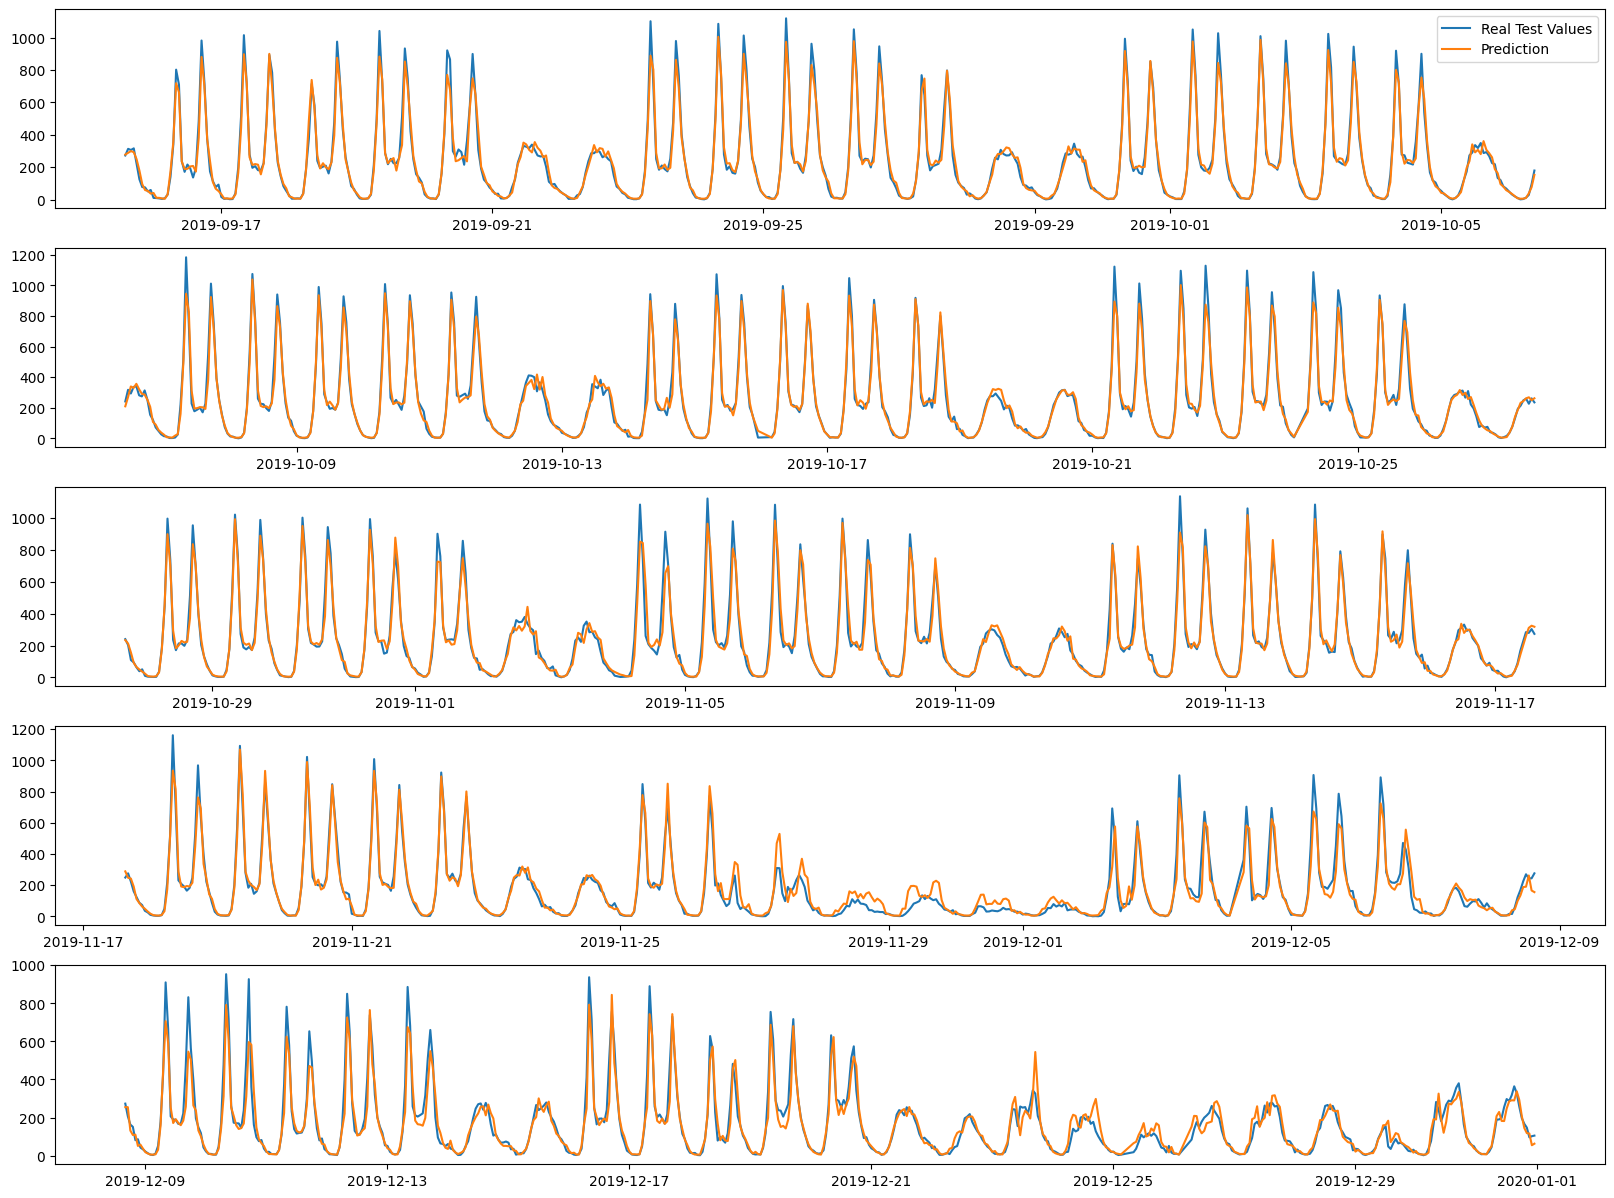

In [21]:
plot, axis = plt.subplots(nrows = 5, ncols = 1, figsize = (20,15))
axis[0].plot(rf_plt_df[['number_of_trips', 'pred']].sort_index()[0:500], label=['Real Test Values', 'Prediction'])
axis[1].plot(rf_plt_df[['number_of_trips', 'pred']].sort_index()[500:1000], label=['Real Test Values', 'Prediction'])
axis[2].plot(rf_plt_df[['number_of_trips', 'pred']].sort_index()[1000:1500], label=['Real Test Values', 'Prediction'])
axis[3].plot(rf_plt_df[['number_of_trips', 'pred']].sort_index()[1500:2000], label=['Real Test Values', 'Prediction'])
axis[4].plot(rf_plt_df[['number_of_trips', 'pred']].sort_index()[2000:], label=['Real Test Values', 'Prediction'])
axis[0].legend(loc='best')


## K-Nearest Neighbors Regression

### Default model

We also use GridSearchCV here, to make the cross validation easier and the results comparable to the actual grid search executions later.
For now we leave out any parameters and just use the model as it is by default.


In [22]:
knn_default_model = KNeighborsRegressor()

knn_default_grid = GridSearchCV(estimator=knn_default_model, param_grid={}, cv=tscv, n_jobs=-1)
knn_default_grid.fit(X_train, y_train)

print("Default model score: ", knn_default_grid.best_score_)

Default model score:  0.9128366710757657


### Parameter tuning

In [23]:
# Improved version using grid search's ability to compare multiple parameters at once
knn_params = {
    "n_neighbors": [1, 3, 5, 7, 10],  # default is 5
    "leaf_size": [1, 15, 30, 50],  # default is 30
    "p": [1, 1.5, 2, 2.5],  # default is 2
    "weights": ["uniform", "distance"],  # default is uniform
}

# n_jobs= -1 means that we use all available cores, which is very important since KNeighborsRegressor is single-threaded by default
knn_grid = GridSearchCV(estimator=KNeighborsRegressor(
), param_grid=knn_params, cv=tscv, n_jobs=-1, verbose=2)
knn_grid.fit(X_train, y_train)


Fitting 3 folds for each of 160 candidates, totalling 480 fits
[CV] END ...leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ..leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.2s
[CV] END ...leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.3s
[CV] END ..leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.3s
[CV] END ..leaf_size=1, n_neighbors=1, p=1, weights=distance; total time=   0.3s
[CV] END ...leaf_size=1, n_neighbors=1, p=2, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=1, p=2, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.4s
[CV] END ..leaf_size=1, n_neighbors=1, p=2, weights=distance; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ..leaf_size=1, n_neighbors=1, p=2, weights=distance; total time=   0.1s
[CV] END ..leaf_size=1, n_neighbors=1, p=2, we

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [1, 15, 30, 50],
                         'n_neighbors': [1, 3, 5, 7, 10], 'p': [1, 1.5, 2, 2.5],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [24]:
print("score: ", knn_grid.best_score_)
print("best parameters: ", knn_grid.best_params_)

score:  0.9179798005692118
best parameters:  {'leaf_size': 1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


#### Visualization of the results

In [25]:
grid_df = pd.DataFrame(knn_grid.cv_results_)
grid_df.sort_values("mean_test_score", inplace=True)
grid_df.reset_index(drop=True, inplace=True)
grid_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.006079      0.000528         0.292635        0.124298   
1       0.009349      0.006518         0.242516        0.073175   
2       0.003994      0.000006         0.245094        0.128670   
3       0.003775      0.000175         0.209111        0.084667   
4       0.007417      0.004940         0.314103        0.132518   

  param_leaf_size param_n_neighbors param_p param_weights  \
0               1                 1       1       uniform   
1              15                 1       1      distance   
2              50                 1       1      distance   
3              30                 1       1       uniform   
4              15                 1       1       uniform   

                                              params  split0_test_score  \
0  {'leaf_size': 1, 'n_neighbors': 1, 'p': 1, 'we...           0.838484   
1  {'leaf_size': 15, 'n_neighbors': 1, 'p': 1, 'w...           0.838484   
2  {'leaf_size': 50, 'n_neighbors': 1, 'p': 1, 'w...           0.838484   
3  {'leaf_size': 30, 'n_neighbors': 1, 'p': 1, 'w...           0.838484   
4  {'leaf_size': 15, 'n_neighbors': 1, 'p': 1, 'w...           0.838484   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.884993           0.921797         0.881758        0.034089   
1           0.884993           0.921797         0.881758        0.034089   
2           0.884993           0.921797         0.881758        0.034089   
3           0.884993           0.921797         0.881758        0.034089   
4           0.884993           0.921797         0.881758        0.034089   

   rank_test_score  
0              153  
1              153  
2              153  
3              153  
4              153

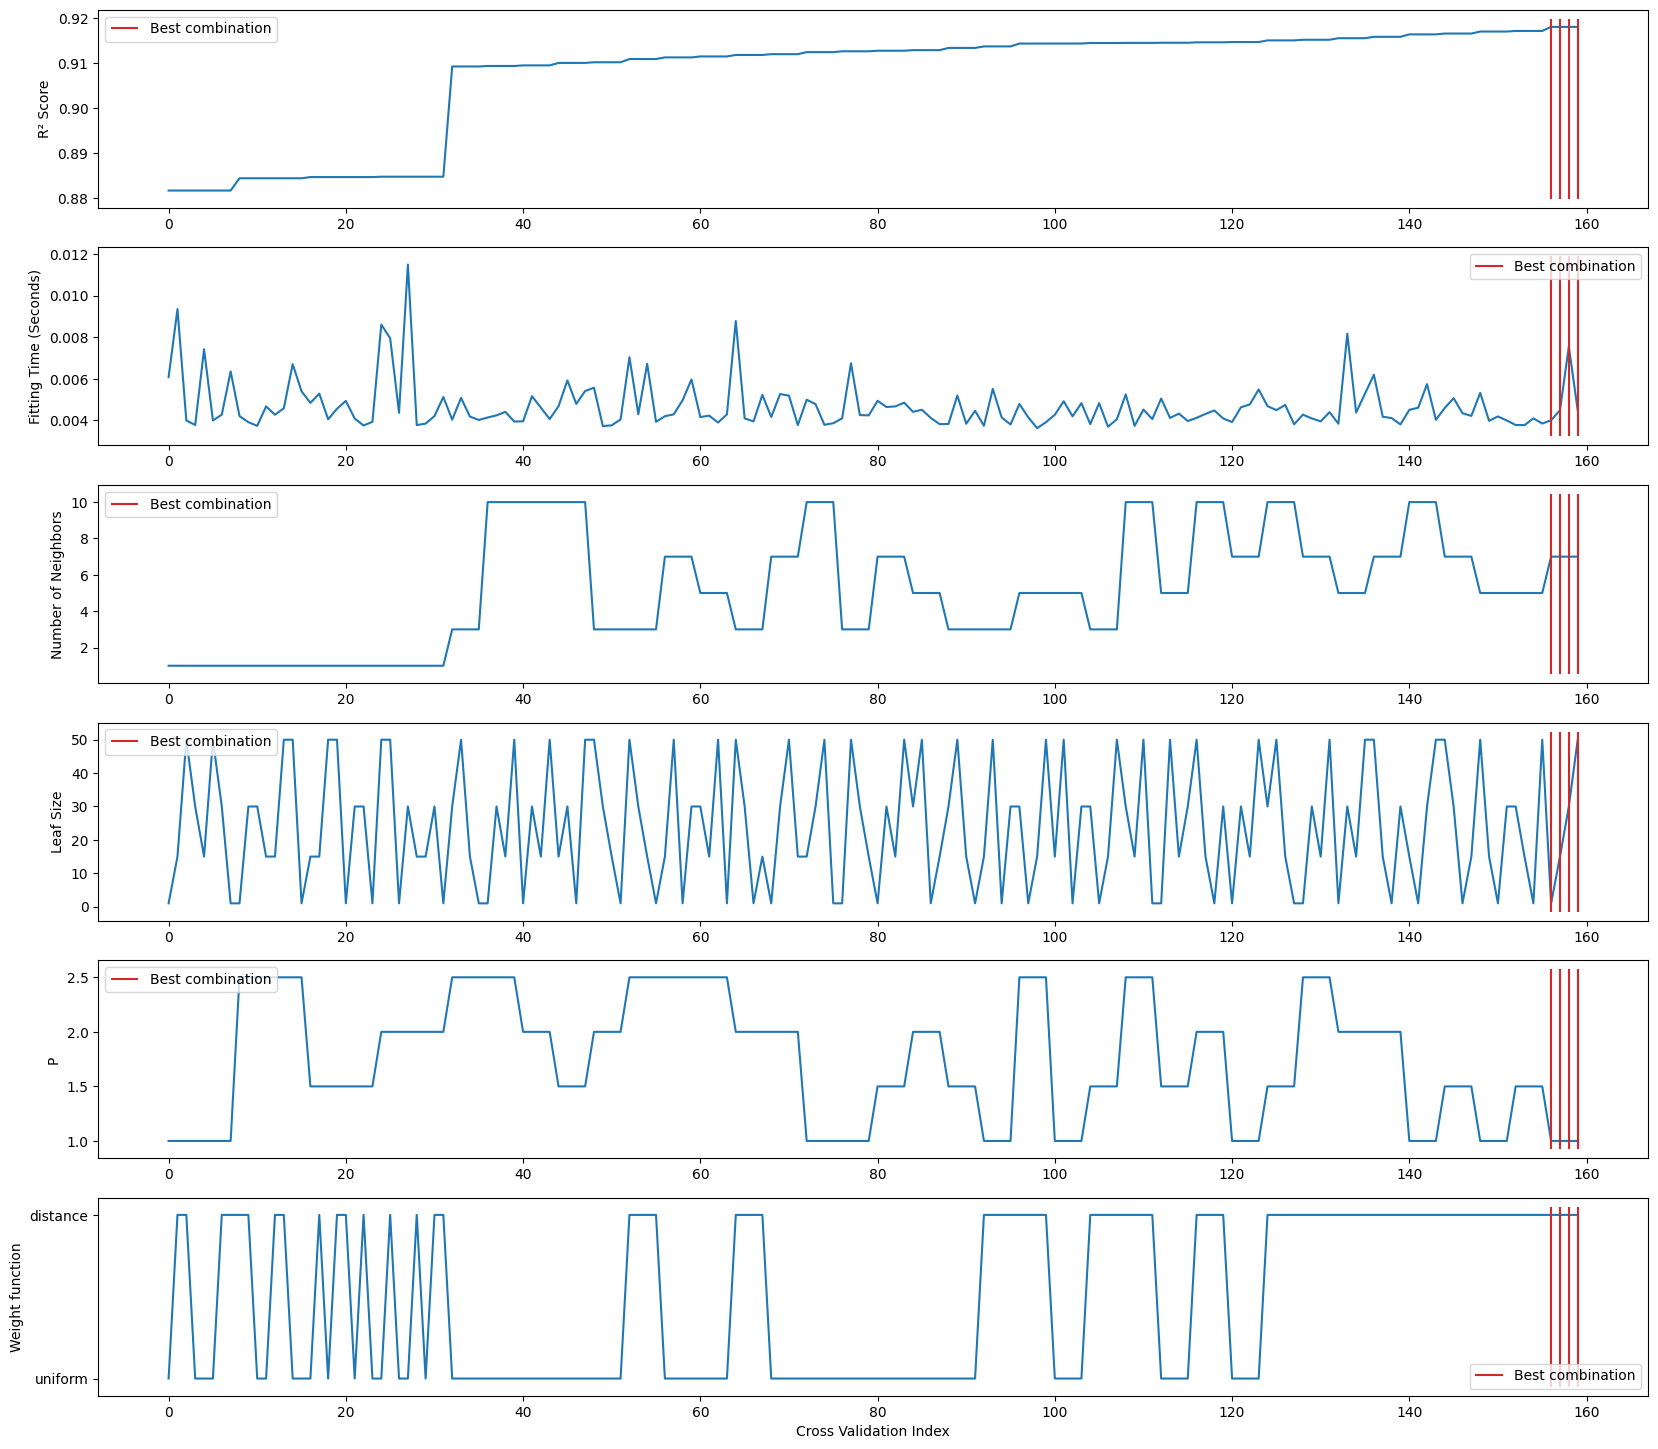

In [26]:
plot, axes = plt.subplots(nrows = 6, ncols = 1, figsize = (20,18))

best_combination = grid_df[grid_df["rank_test_score"] ==1].index

# GridSearchCV uses the scoring function of the estimator (XGBRFRegressor) which in this case is R²
axes[0].plot(grid_df["mean_test_score"])
axes[0].vlines(best_combination, axes[0].get_ylim()[0], axes[0].get_ylim()[1], color="tab:red", label="Best combination") 
axes[0].set_ylabel("R² Score")
axes[0].legend(loc="best")

# It also takes the fitting time into account
axes[1].plot(grid_df["mean_fit_time"])
axes[1].vlines(best_combination, axes[1].get_ylim()[0], axes[1].get_ylim()[1], color="tab:red", label="Best combination") 
axes[1].set_ylabel("Fitting Time (Seconds)")
axes[1].legend(loc="best")

# The selected parameters for tuning are displayed as well
axes[2].plot(grid_df["param_n_neighbors"])
axes[2].vlines(best_combination, axes[2].get_ylim()[0], axes[2].get_ylim()[1], color="tab:red", label="Best combination") 
axes[2].set_ylabel("Number of Neighbors")
axes[2].legend(loc="upper left")

axes[3].plot(grid_df["param_leaf_size"])
axes[3].vlines(best_combination, axes[3].get_ylim()[0], axes[3].get_ylim()[1], color="tab:red", label="Best combination") 
axes[3].set_ylabel("Leaf Size")
axes[3].legend(loc="upper left")

axes[4].plot(grid_df["param_p"])
axes[4].vlines(best_combination, axes[4].get_ylim()[0], axes[4].get_ylim()[1], color="tab:red", label="Best combination") 
axes[4].set_ylabel("P")
axes[4].legend(loc="upper left")

axes[5].plot(grid_df["param_weights"])
axes[5].vlines(best_combination, axes[5].get_ylim()[0], axes[5].get_ylim()[1], color="tab:red", label="Best combination") 
axes[5].set_ylabel("Weight function")
axes[5].set_xlabel("Cross Validation Index")
axes[5].legend(loc="best")

This shows that we have in fact multiple winners.  
The number of neighbors should be definitely above 1, which makes because the model would easily be overfitted otherwise.
The leaf size doesn't seem to matter as long as we set the weight function to "distance" and P to "1".
Especially the much lower leaf size than the default.  
The winner choosen by GridSearch has the following parameters:

- `n_neighbors` : 5
- `leaf_size` : 1
- `p` : 1
- `weights` : "distance"

### Model evaluation

In [27]:
knn_plt_df = pd.DataFrame(y_test).copy()
knn_plt_df['pred'] = knn_grid.best_estimator_.predict(X_test)
knn_plt_df['dif'] = (knn_plt_df.number_of_trips - knn_plt_df.pred).abs()
knn_plt_df['dif_perc'] = knn_plt_df['dif'] / knn_plt_df['number_of_trips']

knn_plt_df

number_of_trips        pred        dif  dif_perc
date_time                                                            
2019-09-15 14:00:00            272.0  259.161619  12.838381  0.047200
2019-09-15 15:00:00            313.0  293.796624  19.203376  0.061353
2019-09-15 16:00:00            306.0  303.700671   2.299329  0.007514
2019-09-15 17:00:00            316.0  305.671000  10.329000  0.032687
2019-09-15 18:00:00            221.0  251.801374  30.801374  0.139373
...                              ...         ...        ...       ...
2019-12-31 19:00:00            167.0  147.894010  19.105990  0.114407
2019-12-31 20:00:00            147.0  104.360288  42.639712  0.290066
2019-12-31 21:00:00             96.0   83.315627  12.684373  0.132129
2019-12-31 22:00:00            102.0   61.721320  40.278680  0.394889
2019-12-31 23:00:00            105.0   54.109462  50.890538  0.484672

[2550 rows x 4 columns]

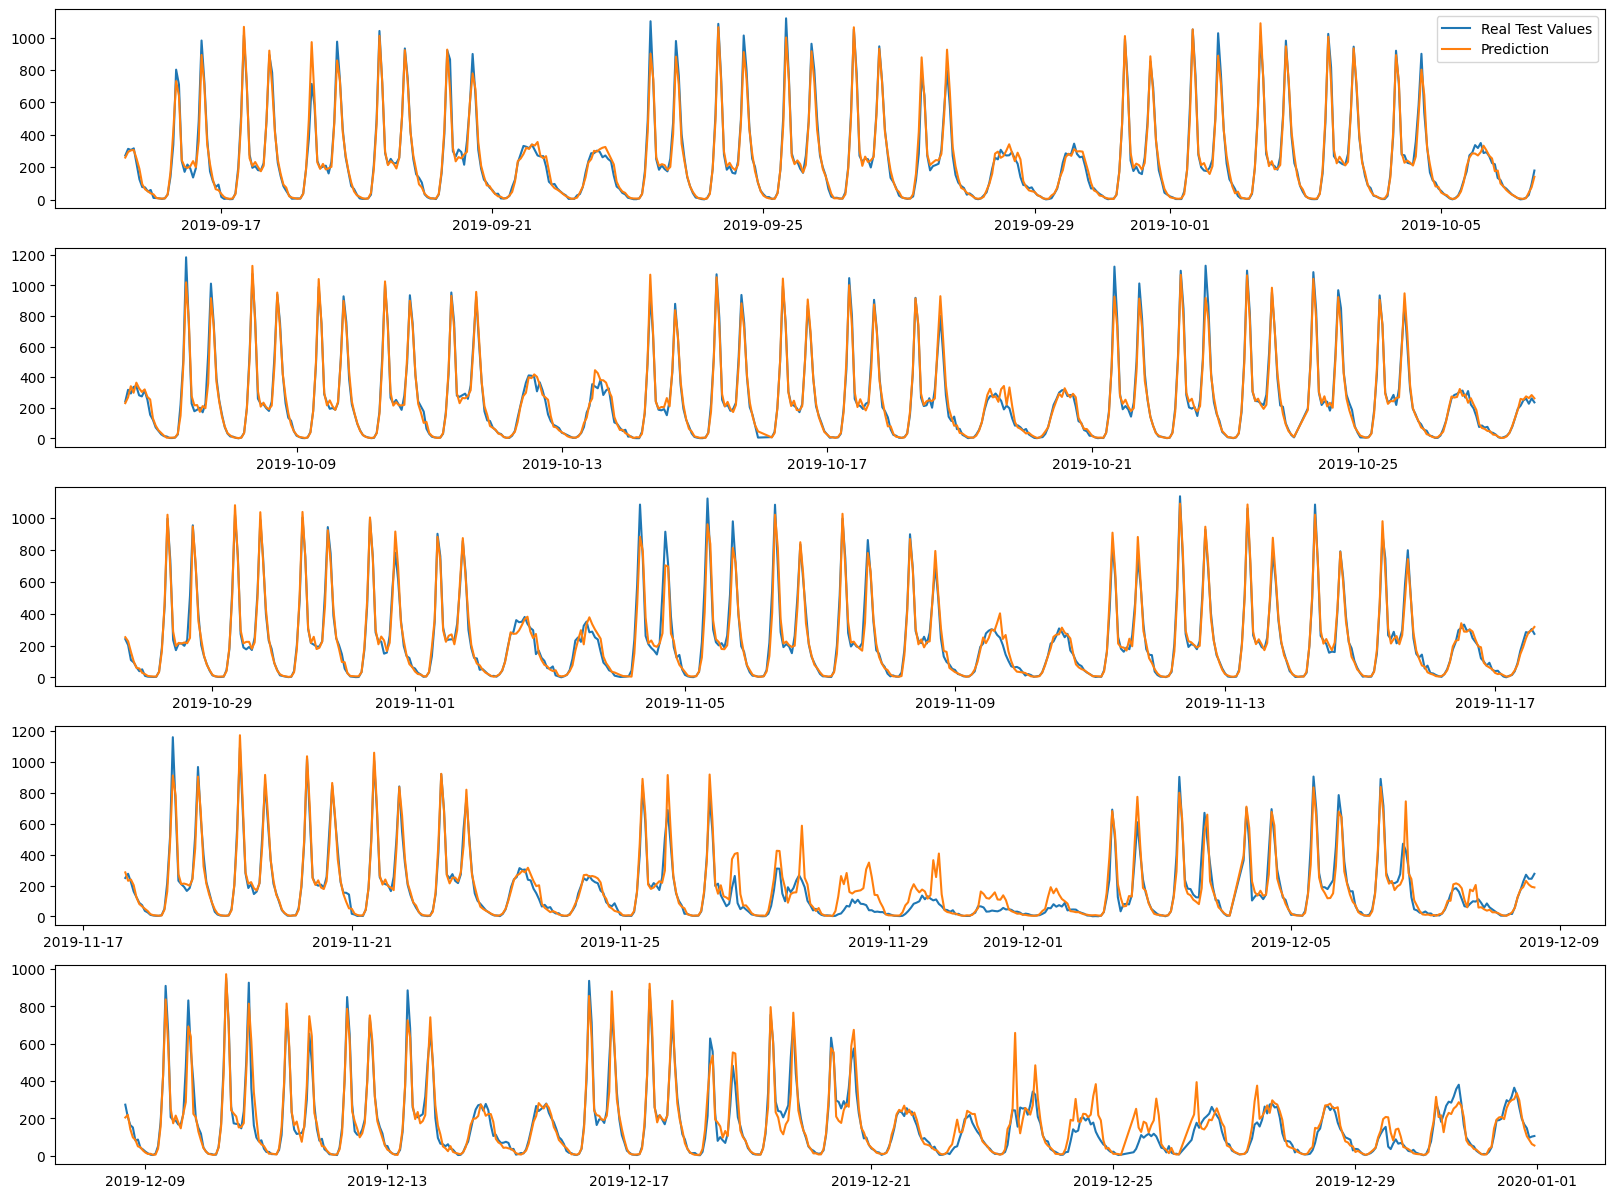

In [28]:
plot, axis = plt.subplots(nrows = 5, ncols = 1, figsize = (20,15))
axis[0].plot(knn_plt_df[['number_of_trips', 'pred']].sort_index()[0:500], label=['Real Test Values', 'Prediction'])
axis[1].plot(knn_plt_df[['number_of_trips', 'pred']].sort_index()[500:1000], label=['Real Test Values', 'Prediction',])
axis[2].plot(knn_plt_df[['number_of_trips', 'pred']].sort_index()[1000:1500], label=['Real Test Values', 'Prediction',])
axis[3].plot(knn_plt_df[['number_of_trips', 'pred']].sort_index()[1500:2000], label=['Real Test Values', 'Prediction',])
axis[4].plot(knn_plt_df[['number_of_trips', 'pred']].sort_index()[2000:], label=['Real Test Values', 'Prediction'])
axis[0].legend(loc='best')

## XGBoost

### Default model

We also use GridSearchCV here, to make the cross validation easier and the results comparable to the actual grid search executions later.
For now we leave out any parameters and just use the model as it is by default.

In [29]:
xgb_default_model = xgb.XGBRFRegressor(random_state=42)

xgb_default_grid = GridSearchCV(estimator=xgb_default_model, param_grid={}, cv=tscv, n_jobs=-1)
xgb_default_grid.fit(X_train, y_train)

print("Default model score: ", xgb_default_grid.best_score_)

Default model score:  0.9079237238497214


Learning rate 1.0
Number of trees 100


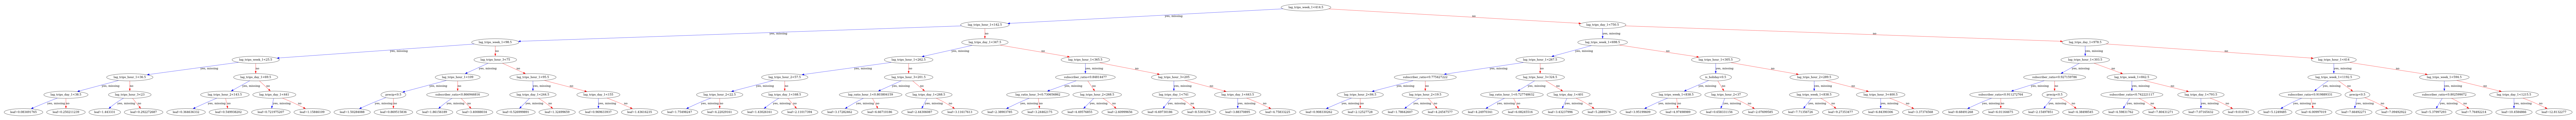

In [30]:
# get some more information about this initial model
default_model = xgb_default_grid.best_estimator_
booster = default_model.get_booster()
plot, axes = plt.subplots(nrows = 1, ncols = 1, figsize=( 100,40))
xgb.plotting.plot_tree(booster, num_trees=0, ax=axes)

print("Learning rate" ,default_model.learning_rate)
print("Number of trees" ,default_model.n_estimators)

As we can see from the generated tree, with default parameters we get a XGBoost Random Forest Regressor with a depth of 7 levels.

### Parameter tuning
Let's try to improve the performance even further by doing a Grid Search  
Hyperparameters chosen based on : https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9 
`learning_rate` and `gamma` values other than the default seem to always have really bad effects on the score  
Instead we've chosen `reg_lambda` and `reg_alpha` for tuning

In [31]:
xgb_params = {'max_depth': [5, 10,15, 20],  # 7 seems to be the default value
              'n_estimators': [50, 70 , 100, 200], # 100 seems to be the default value
              "reg_alpha": [0, 5, 10],  # 0 is the default
              "reg_lambda": [0, 1e-06, 1e-05]  # 1e-05 is default
              }

# cv=3 means that we are using 3 folds generated by KFold
xgb_grid = GridSearchCV(estimator=XGBRFRegressor(random_state=42), param_grid=xgb_params, cv=tscv,verbose=2 )

xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-06; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-06; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-06; total time=   0.2s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-05; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-05; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=0, reg_lambda=1e-05; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=5, reg_lambda=0; total time=   0.1s
[CV] END max_depth=5, n_estimators=50, reg_alpha=5, reg_lambda=

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      in...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      predictor=None, random_state=42,
                                      reg_alpha=None, ...),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'n_estimators': [50, 70, 100, 200],
                         'reg_alpha': [0, 5, 10],
                         'reg_lambda': [0, 1e-06, 1e-05]},
             verbose=2)

In [32]:
# Most important results:
print("score: ", xgb_grid.best_score_)
print("best parameters: ", xgb_grid.best_params_)


score:  0.9238033489978457
best parameters:  {'max_depth': 20, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': 0}


#### Visualization of the results

In [33]:
grid_df = pd.DataFrame(xgb_grid.cv_results_)
grid_df.sort_values("mean_test_score", inplace=True)
grid_df.reset_index(drop=True, inplace=True)
grid_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.429072      0.109843         0.004811        0.000570   
1       0.429261      0.100773         0.004443        0.000166   
2       0.418563      0.111351         0.005167        0.001179   
3       0.420791      0.108968         0.004939        0.000780   
4       0.518114      0.074587         0.005600        0.000957   

  param_max_depth param_n_estimators param_reg_alpha param_reg_lambda  \
0               5                200               0         0.000001   
1               5                200               0                0   
2               5                200               0          0.00001   
3               5                200               5          0.00001   
4               5                200               5         0.000001   

                                              params  split0_test_score  \
0  {'max_depth': 5, 'n_estimators': 200, 'reg_alp...           0.888618   
1  {'max_depth': 5, 'n_estimators': 200, 'reg_alp...           0.888618   
2  {'max_depth': 5, 'n_estimators': 200, 'reg_alp...           0.888623   
3  {'max_depth': 5, 'n_estimators': 200, 'reg_alp...           0.888687   
4  {'max_depth': 5, 'n_estimators': 200, 'reg_alp...           0.888687   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.872120           0.917122         0.892620        0.018588   
1           0.872120           0.917122         0.892620        0.018588   
2           0.872120           0.917121         0.892622        0.018588   
3           0.872446           0.917076         0.892736        0.018444   
4           0.872446           0.917076         0.892736        0.018444   

   rank_test_score  
0              144  
1              143  
2              142  
3              141  
4              140

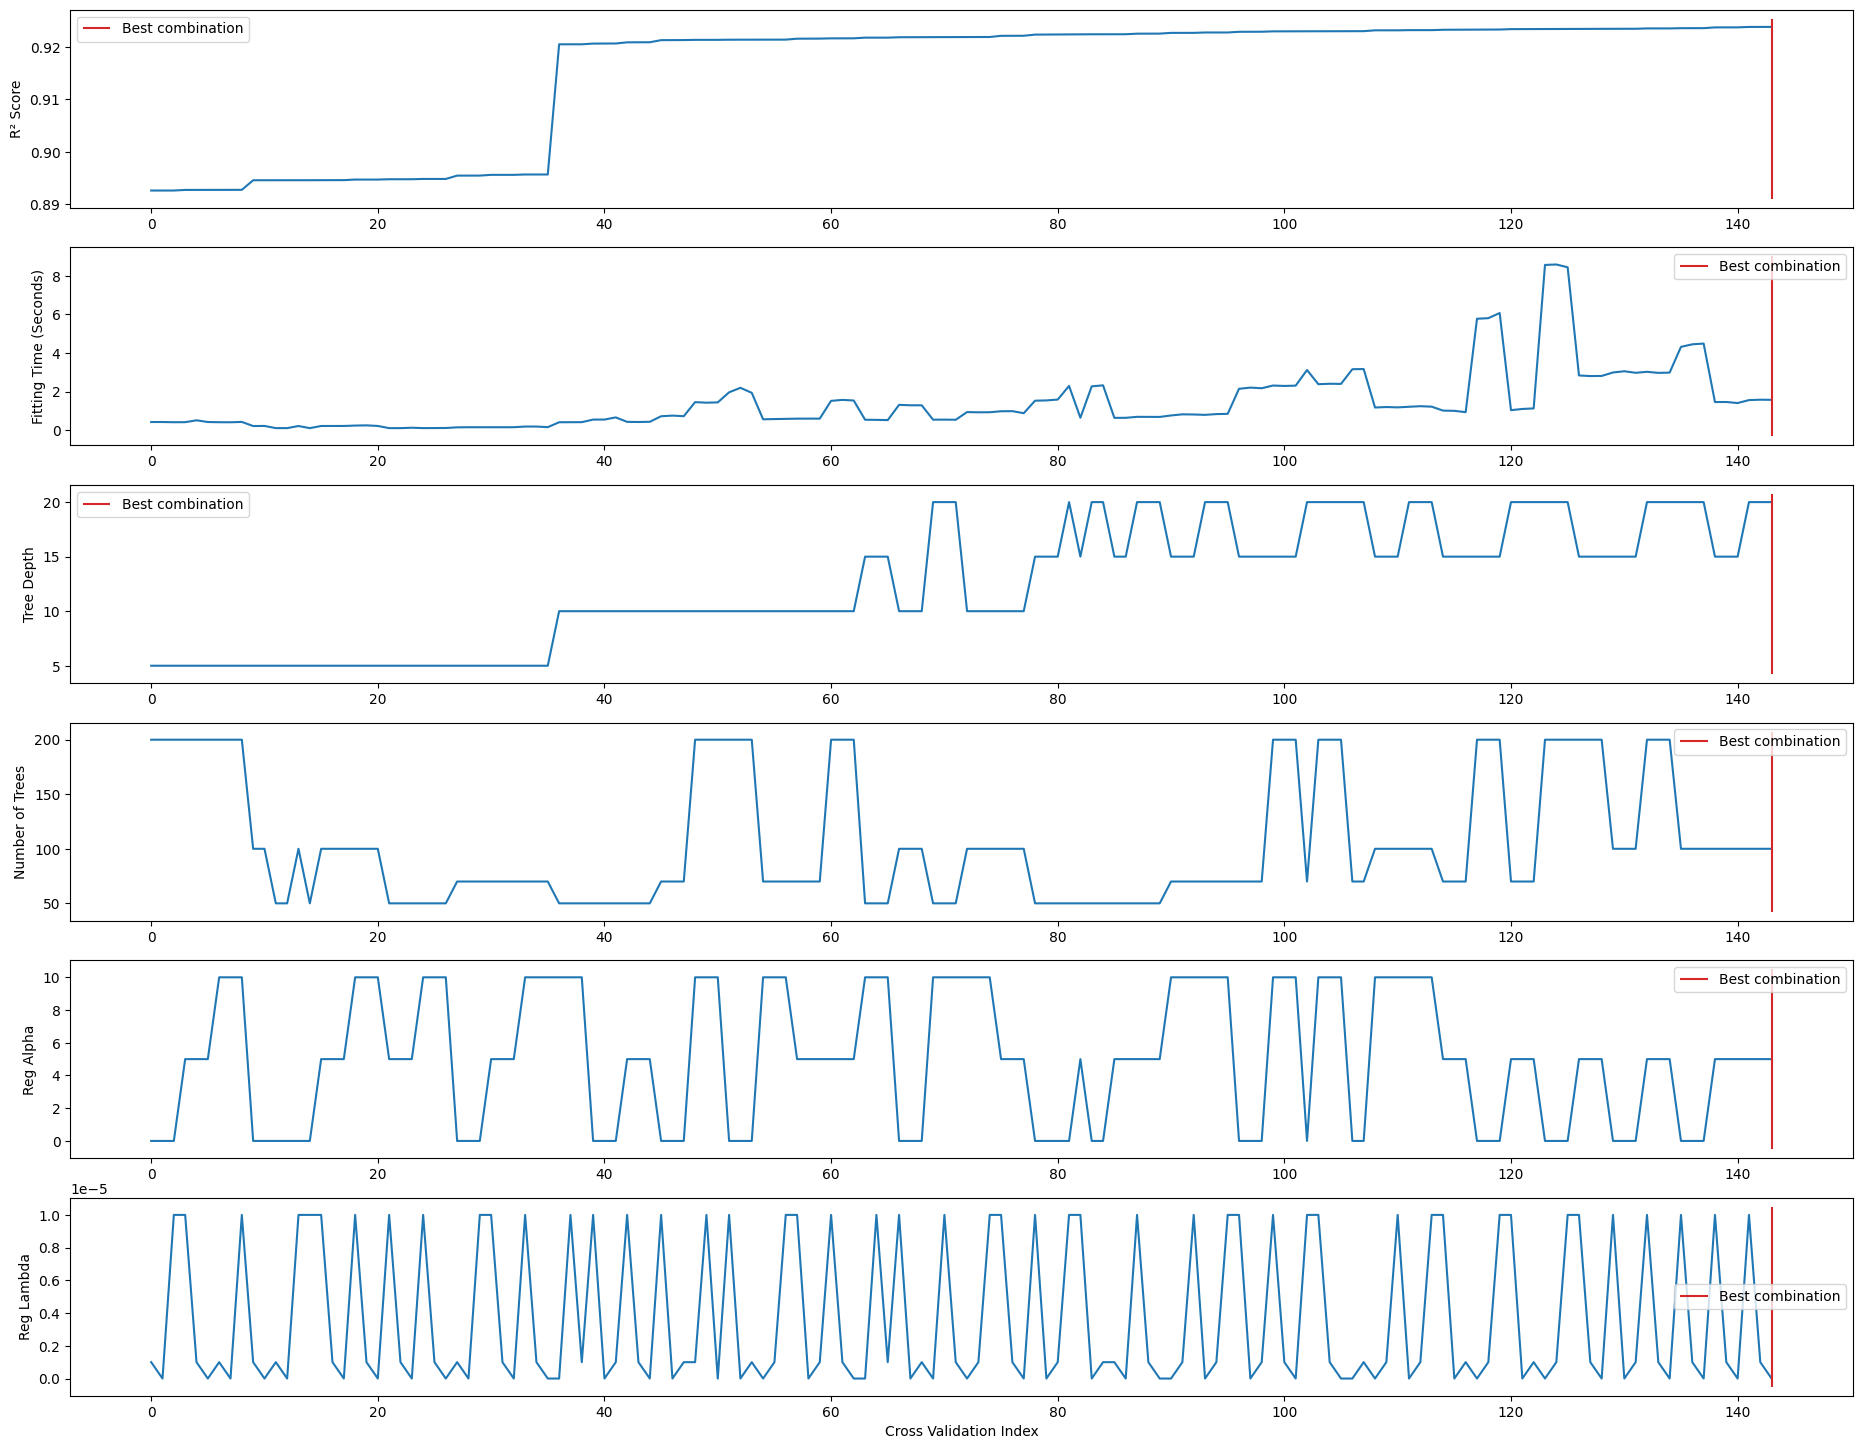

In [34]:
plot, axes = plt.subplots(nrows = 6, ncols = 1, figsize = (23,18))

best_combination = grid_df[grid_df["rank_test_score"] ==1].index

# GridSearchCV uses the scoring function of the estimator (XGBRFRegressor) which in this case is R²
axes[0].plot(grid_df["mean_test_score"])
axes[0].vlines(best_combination, axes[0].get_ylim()[0], axes[0].get_ylim()[1], color="tab:red", label="Best combination") 
axes[0].set_ylabel("R² Score")
axes[0].legend(loc="best")

# It also takes the fitting time into account
axes[1].plot(grid_df["mean_fit_time"])
axes[1].vlines(best_combination, axes[1].get_ylim()[0], axes[1].get_ylim()[1], color="tab:red", label="Best combination") 
axes[1].set_ylabel("Fitting Time (Seconds)")
axes[1].legend(loc="best")

# The selected parameters for tuning are displayed as well
axes[2].plot(grid_df["param_max_depth"])
axes[2].vlines(best_combination, axes[2].get_ylim()[0], axes[2].get_ylim()[1], color="tab:red", label="Best combination") 
axes[2].set_ylabel("Tree Depth")
axes[2].legend(loc="best")

axes[3].plot(grid_df["param_n_estimators"])
axes[3].vlines(best_combination, axes[3].get_ylim()[0], axes[3].get_ylim()[1], color="tab:red", label="Best combination") 
axes[3].set_ylabel("Number of Trees")
axes[3].legend(loc="best")

axes[4].plot(grid_df["param_reg_alpha"])
axes[4].vlines(best_combination, axes[4].get_ylim()[0], axes[4].get_ylim()[1], color="tab:red", label="Best combination") 
axes[4].set_ylabel("Reg Alpha")
axes[4].legend(loc="best")

axes[5].plot(grid_df["param_reg_lambda"])
axes[5].vlines(best_combination, axes[5].get_ylim()[0], axes[5].get_ylim()[1], color="tab:red", label="Best combination") 
axes[5].set_xlabel("Cross Validation Index")
axes[5].set_ylabel("Reg Lambda")
axes[5].legend(loc="best")


This shows that we get the highest performance using a high depth of the tree.  
Secondary the number of trees can also help to boost the performance.  
The parameters to regulate alpha and lambda seem to have a lower impact.

The winner choosen by GridSearchCV has the following parameters:

- `max_depth`: 20, 
- `n_estimators`: 200, 
- `reg_alpha`: 0, 
- `reg_lambda`: 1*10⁻⁶

Note that the performance of this model can be improved even further.  
For example with a maximum depth of 80 and 3200 estimators/ trees we get a score of 0.9473392355769684, which is a tiny bit higher.  
However, the extremely longer fitting time of almost 2 minutes cannot be justified by the small gain.

### Model evaluation

In [35]:
xgb_plt_df = pd.DataFrame(y_test).copy()
xgb_plt_df['pred'] = xgb_grid.best_estimator_.predict(X_test)
xgb_plt_df['dif'] = (xgb_plt_df.number_of_trips - xgb_plt_df.pred).abs()
xgb_plt_df['dif_perc'] = xgb_plt_df['dif'] / xgb_plt_df['number_of_trips']
xgb_plt_df

number_of_trips        pred        dif  dif_perc
date_time                                                            
2019-09-15 14:00:00            272.0  277.365814   5.365814  0.019727
2019-09-15 15:00:00            313.0  283.544769  29.455231  0.094106
2019-09-15 16:00:00            306.0  296.087708   9.912292  0.032393
2019-09-15 17:00:00            316.0  291.062408  24.937592  0.078916
2019-09-15 18:00:00            221.0  251.368042  30.368042  0.137412
...                              ...         ...        ...       ...
2019-12-31 19:00:00            167.0  139.761719  27.238281  0.163103
2019-12-31 20:00:00            147.0  114.835442  32.164558  0.218807
2019-12-31 21:00:00             96.0  113.560562  17.560562  0.182923
2019-12-31 22:00:00            102.0   49.028778  52.971222  0.519326
2019-12-31 23:00:00            105.0   59.002987  45.997013  0.438067

[2550 rows x 4 columns]

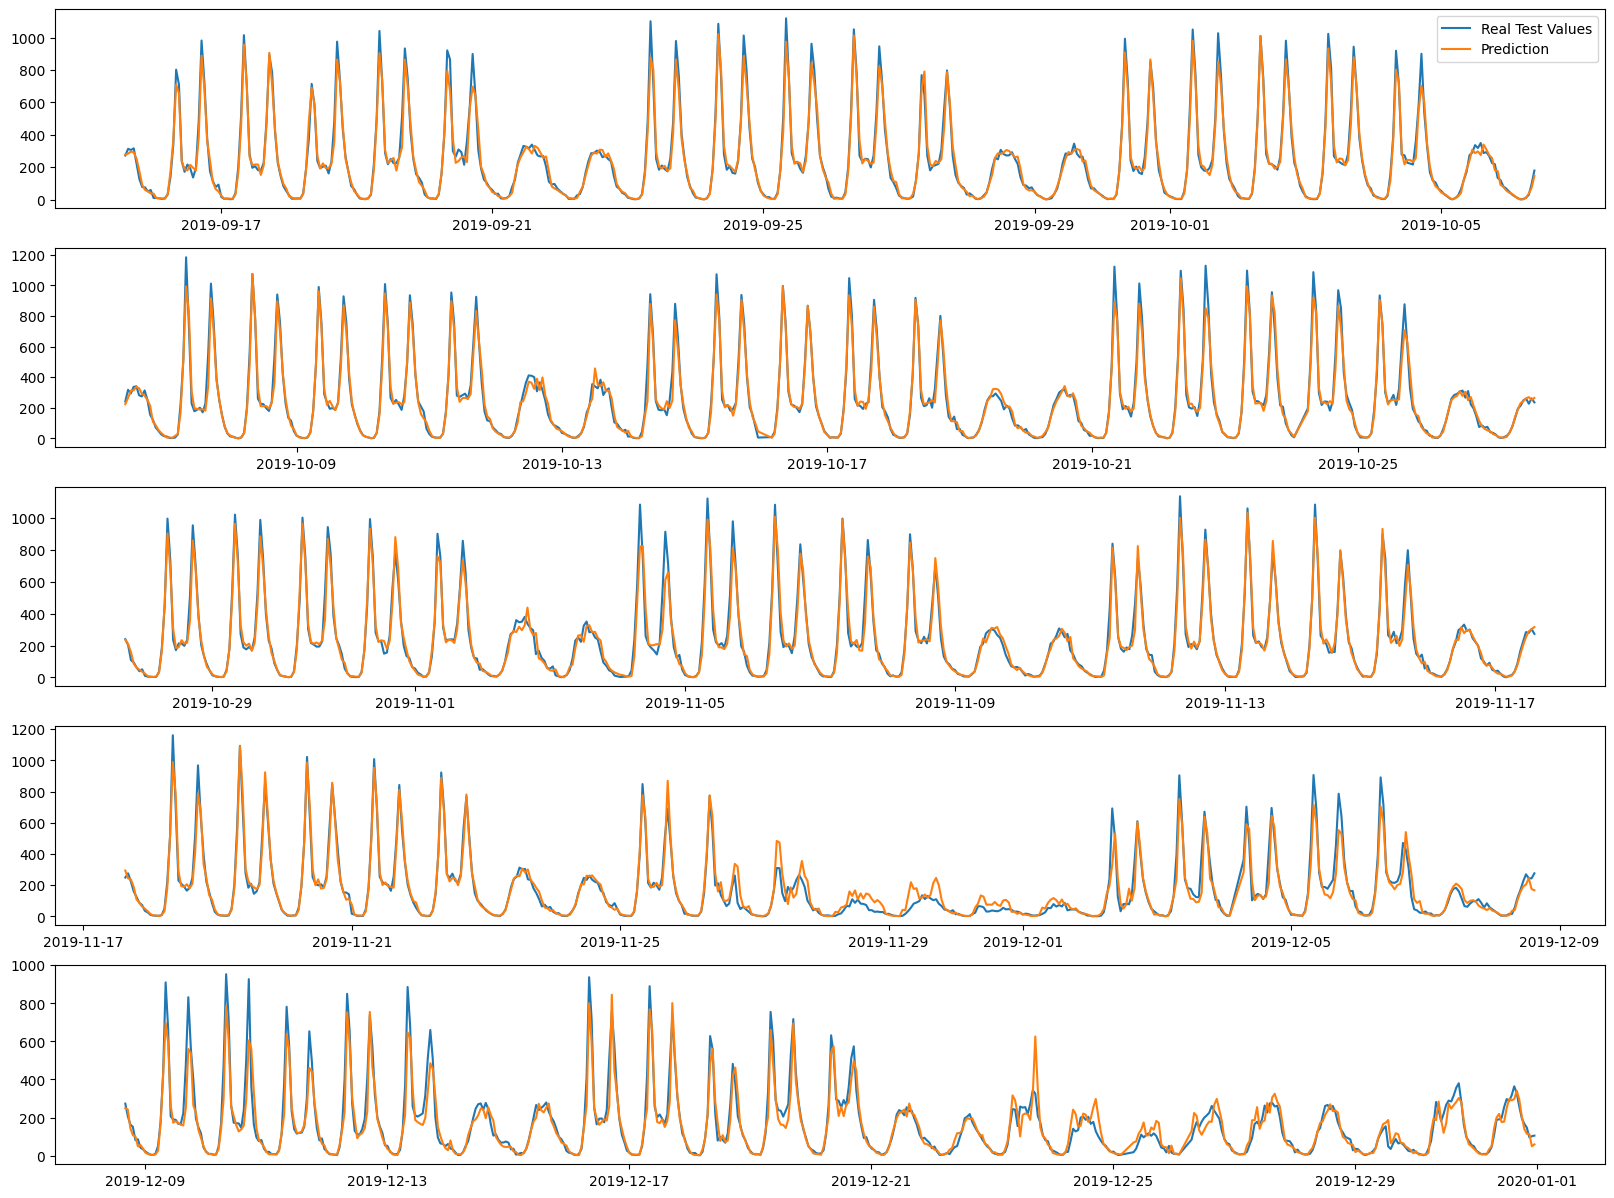

In [36]:
plot, axis = plt.subplots(nrows = 5, ncols = 1, figsize = (20,15))
axis[0].plot(xgb_plt_df[['number_of_trips', 'pred']].sort_index()[0:500], label=['Real Test Values', 'Prediction'])
axis[1].plot(xgb_plt_df[['number_of_trips', 'pred']].sort_index()[500:1000], label=['Real Test Values', 'Prediction'])
axis[2].plot(xgb_plt_df[['number_of_trips', 'pred']].sort_index()[1000:1500], label=['Real Test Values', 'Prediction'])
axis[3].plot(xgb_plt_df[['number_of_trips', 'pred']].sort_index()[1500:2000], label=['Real Test Values', 'Prediction'])
axis[4].plot(xgb_plt_df[['number_of_trips', 'pred']].sort_index()[2000:], label=['Real Test Values', 'Prediction'])
axis[0].legend(loc='best')

## Model comparison and evaluation

Now that we finally found out the best parameters for each model using `GridSearchCV`, we can predict our previously splitted test set and calculate the score.  
This scroe is different from the score that the grid search would show using `grid.best_score_` because it's working on the final test set and not on the cross validated training set.

In [43]:
# Create a df that contains all scores of the optimized and unoptimized values

result_dict = {
    "Model Name": ["RandomForestRegressor", "KNeighborsRegressor", "XGBRFRegressor"],
    "Unoptimized": [
        rf_default_grid.best_estimator_.score(X_test, y_test),
        knn_default_grid.best_estimator_.score(X_test, y_test),
        xgb_default_grid.best_estimator_.score(X_test, y_test)],
    "Optimized": [
        rf_grid.best_estimator_.score(X_test, y_test),
        knn_grid.best_estimator_.score(X_test, y_test),
        xgb_grid.best_estimator_.score(X_test, y_test)],
}

result_df = pd.DataFrame(result_dict)
result_df.set_index("Model Name")

result_df


Model Name  Unoptimized  Optimized
0  RandomForestRegressor     0.954284   0.954296
1    KNeighborsRegressor     0.955088   0.956773
2         XGBRFRegressor     0.946470   0.955571

Model Name|	Unoptimized|	Optimized
---|---|---|
|RandomForestRegressor|	0.954284		|0.954296
|KNeighborsRegressor|	0.955088	|**0.956773**
|XGBRFRegressor|	0.946470	|	0.955571

As you can see, the optimized K-nearest neighbors regressor showed the best performance with an R² value of `0.956773`.

To better show the differences between the unoptimized and the optimized model, we plotted the graph for 150 samples of the test set.

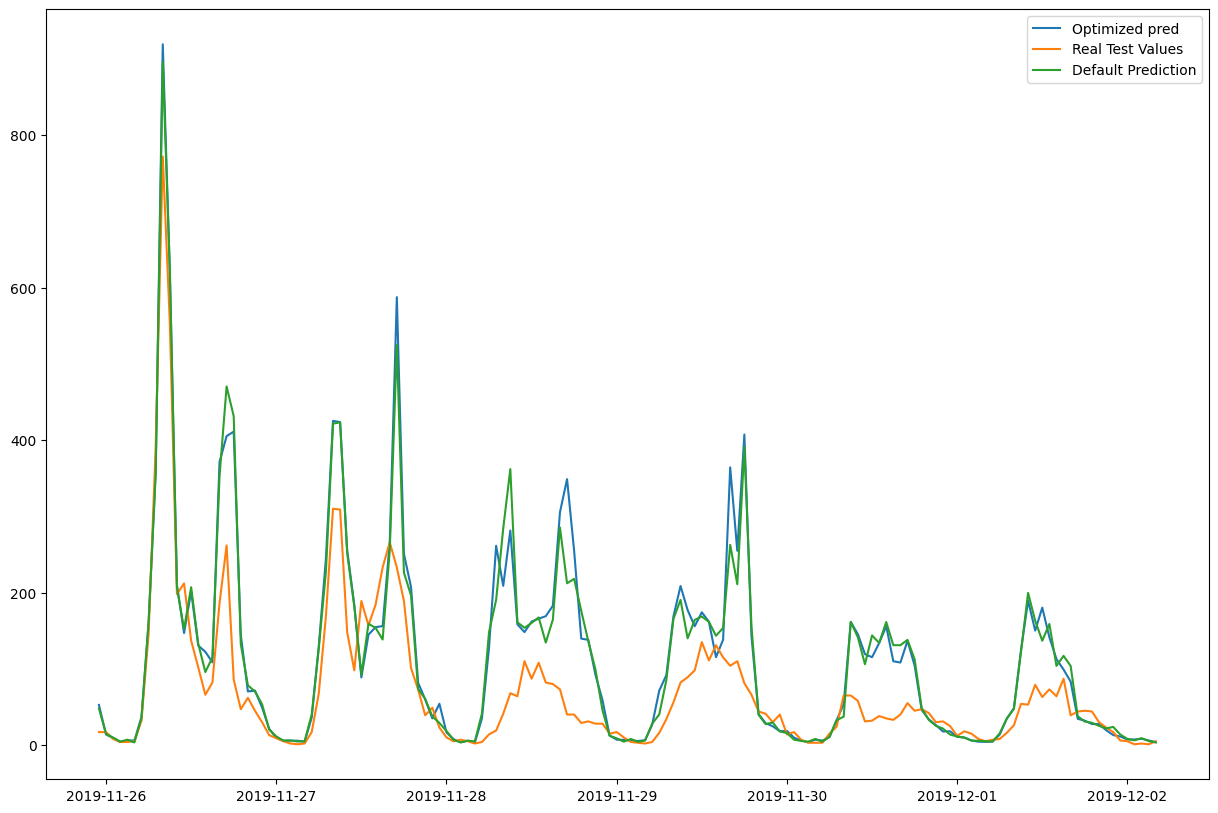

In [48]:
# Show the difference for default and optimized model
plot, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
axis.plot(knn_plt_df[[ 'pred', 'number_of_trips',]].sort_index()[1700:1850], label=['Optimized pred','Real Test Values' ])

#add default values for this plot
knn_plt_df['pred_default'] = knn_default_grid.best_estimator_.predict(X_test)
axis.plot(knn_plt_df[[ 'pred_default',]].sort_index()[1700:1850], label="Default Prediction")

axis.legend(loc='best')

### Feature importance
Now we know that the KNeighborsRegressor showed the best performance, let's find out which features are the most important for that model.
Unfortunately this model doesn't provide a function to get the feature importance, so we show the values for XGBRFRegressor, that comes pretty close in terms of predictive performance.

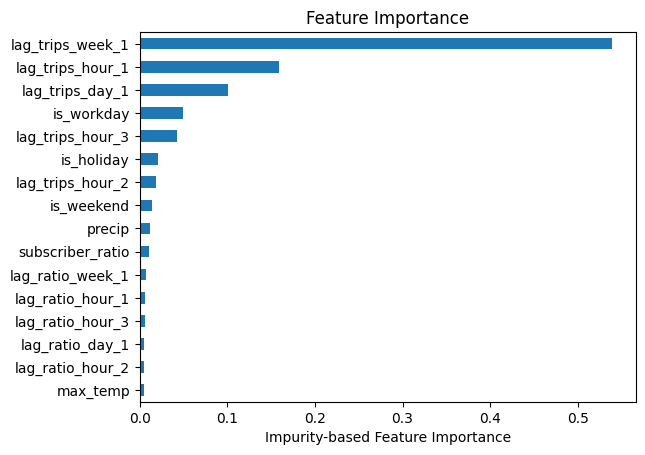

In [49]:
feat_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("Impurity-based Feature Importance")

plt.show()

As you can see, the lag value from one week before (`lag_trips_week_1`) are by far the most imporant feature for the prediction.  
Other lag values (day, hour, etc.) also play a significant role for the prediction.  
Apart from the lag features, `is_workday`, which is composed of `is_weekend` and `is_holiday` also play a minor role.  
The precipitation (`precipitation`) and especially the temperature (`max_temp`) seem to play almost no role for the prediction.

## Outlook 

Further improvement could be achieved by using enhanced weather data for the features. The mild climate in San Francisco with low precipitation and temperature ranges allowing riding a bike all year long have a little influence on the demand. Possible enhancements could be achieved through wind strength and direction since San Francisco's location in a bay area.

In case of the selected prediction models, improvements can be achieved by an advanced hyperparameter tuning. Our computational resources are limited and especially tuning the XGBoost Hyperparameters is cost-intensive.
